# Exploring the importance of model weight norm to grokking in small transformers learning modular addition

This notebook reproduces Figure 7 from the paper [Omnigrok: Grokking Beyond Algorithmic Data](https://arxiv.org/abs/2210.01117), showing how constraining weight norm influences grokking. The setup here is similar to the original paper on grokking from [Power et al.](https://arxiv.org/abs/2201.02177) -- we train small transformer models to do math operations, here modular addition. We use exactly the same setup as Nanda and Lieberum's [A Mechanistic Interpretability Analysis of Grokking](https://www.alignmentforum.org/posts/N6WM6hs7RQMKDhYjB/a-mechanistic-interpretability-analysis-of-grokking). The transformer implementation and the choice of hyperparameters is taken directly from [Neel's colab notebook](https://colab.research.google.com/drive/1F6_1_cWXE5M7WocUcpQWp3v8z4b1jL20). We'll see that constraining optimization to lie on a hypersphere of constant model weight norm significantly changes the learning dynamics, bringing train and test accuracy curves together.

### Imports

In [ ]:
!nvidia-smi

Tue Oct  4 18:16:15 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import random
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import einops
from tqdm.auto import tqdm

import matplotlib.pyplot as plt

### Transformer implementation

In [ ]:
# This code was taken directly from Neel Nanda's study of grokking:
# https://colab.research.google.com/drive/1F6_1_cWXE5M7WocUcpQWp3v8z4b1jL20

class HookPoint(nn.Module):
    def __init__(self):
        super().__init__()
        self.fwd_hooks = []
        self.bwd_hooks = []
    
    def give_name(self, name):
        # Called by the model at initialisation
        self.name = name
    
    def add_hook(self, hook, dir='fwd'):
        # Hook format is fn(activation, hook_name)
        # Change it into PyTorch hook format (this includes input and output, 
        # which are the same for a HookPoint)
        def full_hook(module, module_input, module_output):
            return hook(module_output, name=self.name)
        if dir=='fwd':
            handle = self.register_forward_hook(full_hook)
            self.fwd_hooks.append(handle)
        elif dir=='bwd':
            handle = self.register_backward_hook(full_hook)
            self.bwd_hooks.append(handle)
        else:
            raise ValueError(f"Invalid direction {dir}")
    
    def remove_hooks(self, dir='fwd'):
        if (dir=='fwd') or (dir=='both'):
            for hook in self.fwd_hooks:
                hook.remove()
            self.fwd_hooks = []
        if (dir=='bwd') or (dir=='both'):
            for hook in self.bwd_hooks:
                hook.remove()
            self.bwd_hooks = []
        if dir not in ['fwd', 'bwd', 'both']:
            raise ValueError(f"Invalid direction {dir}")
    
    def forward(self, x):
        return x


In [ ]:
# Embed & Unembed
class Embed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_E = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_model))
    
    def forward(self, x):
        return torch.einsum('dbp -> bpd', self.W_E[:, x])

class Unembed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_U = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_vocab))
    
    def forward(self, x):
        return (x @ self.W_U)

# Positional Embeddings
class PosEmbed(nn.Module):
    def __init__(self, max_ctx, d_model):
        super().__init__()
        self.W_pos = nn.Parameter(torch.randn(max_ctx, d_model)/np.sqrt(d_model))
    
    def forward(self, x):
        return x+self.W_pos[:x.shape[-2]]

# LayerNorm
class LayerNorm(nn.Module):
    def __init__(self, d_model, epsilon = 1e-4, model=[None]):
        super().__init__()
        self.model = model
        self.w_ln = nn.Parameter(torch.ones(d_model))
        self.b_ln = nn.Parameter(torch.zeros(d_model))
        self.epsilon = epsilon
    
    def forward(self, x):
        if self.model[0].use_ln:
            x = x - x.mean(axis=-1)[..., None]
            x = x / (x.std(axis=-1)[..., None] + self.epsilon)
            x = x * self.w_ln
            x = x + self.b_ln
            return x
        else:
            return x

# Attention
class Attention(nn.Module):
    def __init__(self, d_model, num_heads, d_head, n_ctx, model):
        super().__init__()
        self.model = model
        self.W_K = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_Q = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_V = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_O = nn.Parameter(torch.randn(d_model, d_head * num_heads)/np.sqrt(d_model))
        self.register_buffer('mask', torch.tril(torch.ones((n_ctx, n_ctx))))
        self.d_head = d_head
        self.hook_k = HookPoint()
        self.hook_q = HookPoint()
        self.hook_v = HookPoint()
        self.hook_z = HookPoint()
        self.hook_attn = HookPoint()
        self.hook_attn_pre = HookPoint()

    def forward(self, x):
        k = self.hook_k(torch.einsum('ihd,bpd->biph', self.W_K, x))
        q = self.hook_q(torch.einsum('ihd,bpd->biph', self.W_Q, x))
        v = self.hook_v(torch.einsum('ihd,bpd->biph', self.W_V, x))
        attn_scores_pre = torch.einsum('biph,biqh->biqp', k, q)
        attn_scores_masked = torch.tril(attn_scores_pre) - 1e10 * (1 - self.mask[:x.shape[-2], :x.shape[-2]])
        attn_matrix = self.hook_attn(F.softmax(self.hook_attn_pre(attn_scores_masked/np.sqrt(self.d_head)), dim=-1))
        z = self.hook_z(torch.einsum('biph,biqp->biqh', v, attn_matrix))
        z_flat = einops.rearrange(z, 'b i q h -> b q (i h)')
        out = torch.einsum('df,bqf->bqd', self.W_O, z_flat)
        return out

# MLP Layers
class MLP(nn.Module):
    def __init__(self, d_model, d_mlp, act_type, model):
        super().__init__()
        self.model = model
        self.W_in = nn.Parameter(torch.randn(d_mlp, d_model)/np.sqrt(d_model))
        self.b_in = nn.Parameter(torch.zeros(d_mlp))
        self.W_out = nn.Parameter(torch.randn(d_model, d_mlp)/np.sqrt(d_model))
        self.b_out = nn.Parameter(torch.zeros(d_model))
        self.act_type = act_type
        # self.ln = LayerNorm(d_mlp, model=self.model)
        self.hook_pre = HookPoint()
        self.hook_post = HookPoint()
        assert act_type in ['ReLU', 'GeLU']
        
    def forward(self, x):
        x = self.hook_pre(torch.einsum('md,bpd->bpm', self.W_in, x) + self.b_in)
        if self.act_type=='ReLU':
            x = F.relu(x)
        elif self.act_type=='GeLU':
            x = F.gelu(x)
        x = self.hook_post(x)
        x = torch.einsum('dm,bpm->bpd', self.W_out, x) + self.b_out
        return x

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model):
        super().__init__()
        self.model = model
        # self.ln1 = LayerNorm(d_model, model=self.model)
        self.attn = Attention(d_model, num_heads, d_head, n_ctx, model=self.model)
        # self.ln2 = LayerNorm(d_model, model=self.model)
        self.mlp = MLP(d_model, d_mlp, act_type, model=self.model)
        self.hook_attn_out = HookPoint()
        self.hook_mlp_out = HookPoint()
        self.hook_resid_pre = HookPoint()
        self.hook_resid_mid = HookPoint()
        self.hook_resid_post = HookPoint()
    
    def forward(self, x):
        x = self.hook_resid_mid(x + self.hook_attn_out(self.attn((self.hook_resid_pre(x)))))
        x = self.hook_resid_post(x + self.hook_mlp_out(self.mlp((x))))
        return x

# Full transformer
class Transformer(nn.Module):
    def __init__(self, num_layers, d_vocab, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, use_cache=False, use_ln=True):
        super().__init__()
        self.cache = {}
        self.use_cache = use_cache

        self.embed = Embed(d_vocab, d_model)
        self.pos_embed = PosEmbed(n_ctx, d_model)
        self.blocks = nn.ModuleList([TransformerBlock(d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model=[self]) for i in range(num_layers)])
        # self.ln = LayerNorm(d_model, model=[self])
        self.unembed = Unembed(d_vocab, d_model)
        self.use_ln = use_ln

        for name, module in self.named_modules():
            if type(module)==HookPoint:
                module.give_name(name)
    
    def forward(self, x):
        x = self.embed(x)
        x = self.pos_embed(x)
        for block in self.blocks:
            x = block(x)
        # x = self.ln(x)
        x = self.unembed(x)
        return x

    def set_use_cache(self, use_cache):
        self.use_cache = use_cache
    
    def hook_points(self):
        return [module for name, module in self.named_modules() if 'hook' in name]

    def remove_all_hooks(self):
        for hp in self.hook_points():
            hp.remove_hooks('fwd')
            hp.remove_hooks('bwd')
    
    def cache_all(self, cache, incl_bwd=False):
        # Caches all activations wrapped in a HookPoint
        def save_hook(tensor, name):
            cache[name] = tensor.detach()
        def save_hook_back(tensor, name):
            cache[name+'_grad'] = tensor[0].detach()
        for hp in self.hook_points():
            hp.add_hook(save_hook, 'fwd')
            if incl_bwd:
                hp.add_hook(save_hook_back, 'bwd')

### Baseline training run

In [ ]:
def full_loss(model, data, device):
    loader = torch.utils.data.DataLoader(data, batch_size=len(data), shuffle=False)
    # Take the final position only
    x, labels = next(iter(loader))
    x = x.to(device)
    labels = labels.to(device)
    logits = model(x)[:, -1]
    return torch.nn.functional.cross_entropy(logits, labels)

def full_accuracy(model, data, device):
    loader = torch.utils.data.DataLoader(data, batch_size=len(data), shuffle=False)
    # Take the final position only
    x, labels = next(iter(loader))
    x = x.to(device)
    labels = labels.to(device)
    logits = model(x)[:, -1]
    predictions = torch.argmax(logits, dim=1)
    return torch.sum(predictions == labels).item() / len(labels)

In [ ]:
seed = 42
p = 113
fraction = 0.3

In [ ]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.set_default_dtype(torch.float64)
print(f"Using {device}")

Using cuda:0


In [ ]:
equals_token = p
x, y = torch.meshgrid(torch.arange(p), torch.arange(p), indexing='ij')
x = x.flatten()
y = y.flatten()
# plus = torch.ones(x.shape, dtype=torch.int64) * plus_token
equals = torch.ones(x.shape, dtype=torch.int64) * equals_token
prompts = torch.stack([x, y, equals], dim=1).to(device)
answers = ((x + y) % p).to(device)

data = torch.utils.data.TensorDataset(prompts, answers)
train, test = torch.utils.data.random_split(data, 
                                [int(fraction * len(data)),
                                len(data) - int(fraction * len(data))
                                ])

model = Transformer(num_layers=1, 
                    d_vocab=equals_token+1, 
                    d_model=128,
                    d_mlp=512,
                    d_head=32,
                    num_heads=4,
                    n_ctx=3, # context length
                    act_type='ReLU', 
                    use_cache=False, 
                    use_ln=False # use LayerNorm
                ).to(device)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1.0, betas=(0.9, 0.98))
log_steps = []
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
norms = []
for epoch in tqdm(range(15000)):
    train_loss = full_loss(model, train, device)
    if epoch % 30 == 0:
        with torch.no_grad():
            log_steps.append(epoch)
            test_loss = full_loss(model, test, device)
            train_losses.append(train_loss.item())
            test_losses.append(test_loss.item())
            train_accuracies.append(full_accuracy(model, train, device))
            test_accuracies.append(full_accuracy(model, test, device))
            norms.append(np.sqrt(sum(param.pow(2).sum().item() for param in model.parameters())))
    train_loss.backward()
    optimizer.step()
    optimizer.zero_grad()


  0%|          | 0/15000 [00:00<?, ?it/s]

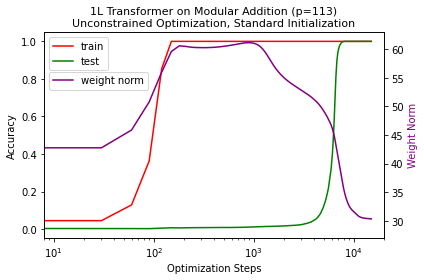

In [ ]:
ax = plt.subplot(1, 1, 1)
plt.plot(log_steps, train_accuracies, color='red', label='train')
plt.plot(log_steps, test_accuracies, color='green', label='test')
plt.legend()
plt.xlabel("Optimization Steps")
plt.xlim(8, 2*10**4)
ax.set_ylabel("Accuracy")
ax2 = ax.twinx()
ax2.set_ylabel("Weight Norm", color='purple')
ax2.plot(log_steps, norms, color='purple', label='weight norm')
ax2.set_ylim(27, 63)
plt.xscale('log')
plt.legend(loc=(0.015, 0.72))
plt.title("1L Transformer on Modular Addition (p=113)\nUnconstrained Optimization, Standard Initialization", fontsize=11)
plt.tight_layout()


The L2 norm of the model's trainable parameters (viewed as a big vector in parameter space) increases when the model overfits, but then decreases when the model generalizes, finishing below the norm of the parameters at initialization! Neel Nanda observed this behavior in [this section of his notebook](https://colab.research.google.com/drive/1F6_1_cWXE5M7WocUcpQWp3v8z4b1jL20#scrollTo=BMOjY3pTjQkA), describing the decrease in weight norm as the model "cleaning up" parts of the network that were previously used to memorize, leaving behind circuits which generalize nicely.

Next we'll do something weird, which is (1) to rescale the initial model parameters down by 0.8x and (2) constrain the optimization so that weight norm is constant throughout training. We constrain optimization by, at each step of training, simply taking an optimizer (Adam) step, but then multiplying all the parameters by (initial norm / new norm), projecting us back onto the constant-norm hypersphere in parameter space.

### Constrained training run

In [ ]:
seed = 42
p = 113
fraction = 0.3

In [ ]:
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
torch.set_default_dtype(torch.float64)
print(f"Using {device}")

Using cuda:0


In [ ]:
equals_token = p
x, y = torch.meshgrid(torch.arange(p), torch.arange(p), indexing='ij')
x = x.flatten()
y = y.flatten()
# plus = torch.ones(x.shape, dtype=torch.int64) * plus_token
equals = torch.ones(x.shape, dtype=torch.int64) * equals_token
prompts = torch.stack([x, y, equals], dim=1).to(device)
answers = ((x + y) % p).to(device)

data = torch.utils.data.TensorDataset(prompts, answers)
train, test = torch.utils.data.random_split(data, 
                                [int(fraction * len(data)),
                                len(data) - int(fraction * len(data))
                                ])

model = Transformer(num_layers=1, 
                    d_vocab=equals_token+1, 
                    d_model=128,
                    d_mlp=512,
                    d_head=32,
                    num_heads=4,
                    n_ctx=3, # context length
                    act_type='ReLU', 
                    use_cache=False, 
                    use_ln=False # use LayerNorm
                ).to(device)

In [ ]:
alpha = 0.8
with torch.no_grad():
    for param in model.parameters():
        param.data *= alpha
    norm = np.sqrt(sum(param.pow(2).sum().item() for param in model.parameters()))

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.0, betas=(0.9, 0.98))
log_steps = []
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
norms = []
for epoch in tqdm(range(15000)):
    train_loss = full_loss(model, train, device)
    if epoch % 10 == 0:
        with torch.no_grad():
            log_steps.append(epoch)
            test_loss = full_loss(model, test, device)
            train_losses.append(train_loss.item())
            test_losses.append(test_loss.item())
            train_accuracies.append(full_accuracy(model, train, device))
            test_accuracies.append(full_accuracy(model, test, device))
            norms.append(np.sqrt(sum(param.pow(2).sum().item() for param in model.parameters())))
    train_loss.backward()
    optimizer.step()
    with torch.no_grad():
        new_norm = np.sqrt(sum(param.pow(2).sum().item() for param in model.parameters()))
        for param in model.parameters():
            param.data *= norm / new_norm
    optimizer.zero_grad()


  0%|          | 0/15000 [00:00<?, ?it/s]

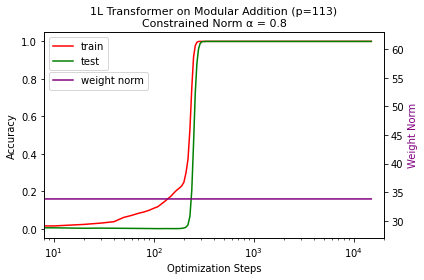

In [ ]:
ax = plt.subplot(1, 1, 1)
plt.plot(log_steps, train_accuracies, color='red', label='train')
plt.plot(log_steps, test_accuracies, color='green', label='test')
plt.legend()
plt.xlabel("Optimization Steps")
plt.xlim(8, 2*10**4)
ax.set_ylabel("Accuracy")
ax2 = ax.twinx()
ax2.set_ylabel("Weight Norm", color='purple')
ax2.plot(log_steps, norms, color='purple', label='weight norm')
ax2.set_ylim(27, 63)
plt.xscale('log')
plt.legend(loc=(0.015, 0.72))
plt.title("1L Transformer on Modular Addition (p=113)\nConstrained Norm α = 0.8", fontsize=11)
plt.tight_layout()

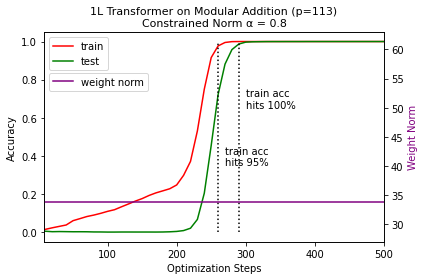

In [ ]:
# LINEAR X-AXIS SCALE

time_to_100_pct_train = log_steps[min(i for i, acc in enumerate(train_accuracies) if acc == 1.0)]
time_to_95_pct_train = log_steps[min(i for i, acc in enumerate(train_accuracies) if acc >= 0.95)]

ax = plt.subplot(1, 1, 1)
plt.plot(log_steps, train_accuracies, color='red', label='train')
plt.plot(log_steps, test_accuracies, color='green', label='test')
plt.legend()
plt.xlabel("Optimization Steps")
plt.xlim(8, 500)

plt.plot([time_to_95_pct_train]*2, [0, 1], color='black', linestyle='dotted')
plt.text(time_to_95_pct_train+10, 0.35, "train acc\nhits 95%")

plt.plot([time_to_100_pct_train]*2, [0, 1], color='black', linestyle='dotted')
plt.text(time_to_100_pct_train+10, 0.65, "train acc\nhits 100%")
ax.set_ylabel("Accuracy")

ax2 = ax.twinx()
ax2.set_ylabel("Weight Norm", color='purple')
ax2.plot(log_steps, norms, color='purple', label='weight norm')
ax2.set_ylim(27, 63)
plt.legend(loc=(0.015, 0.72))
plt.title("1L Transformer on Modular Addition (p=113)\nConstrained Norm α = 0.8", fontsize=11)
plt.tight_layout()

 The train and test curves are still distinct, but constraining weight norm brings the train and test curves quite close together, especially relative to the gap of 1000s of steps for the baseline run! I haven't yet figured out the exactly optimal α for de-grokking training, but dropping α too low prevents the network from even fitting the train set. A higher α de-groks less effectively, bringing test loss in, just not as much.